In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

# fix random seed for more reproducibility and comparability
seed = 7
tf.random.set_seed(seed)

In [134]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_clean.csv')
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,51.30,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,38.72,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,35.17,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,32.78,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,31.51,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,0,0,77.89,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
853,0,1,85.18,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
854,0,0,77.49,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
855,0,1,63.33,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [135]:
all_inputs = df[df.loc[:, "Gender":].columns.values.tolist()].values

all_labels = df['Grade'].values

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

# Generate the same cross validation strategy for all classifiers for better comparison
cross_validation = StratifiedKFold(n_splits=5)

# Classifier/Model Results dictionary
results = {}

#### Function to test the Model/Classifier

In [136]:
def test_model(model, parameters):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cross_validation, n_jobs=-1)
    grid_result = grid_search.fit(all_inputs, all_labels)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result

### Decision Tree With Hyperparameterization

In [137]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],}

result = test_model(decision_tree_classifier, parameter_grid)

results['Decision Tree'] = result

Best: 0.869319 using {'criterion': 'entropy', 'max_depth': 6, 'max_features': 11, 'splitter': 'best'}
0.624371 (0.079699) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'best'}
0.593907 (0.010427) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'random'}
0.600843 (0.051500) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'splitter': 'best'}
0.660628 (0.102894) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'splitter': 'random'}
0.741214 (0.098453) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 3, 'splitter': 'best'}
0.617258 (0.046427) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 3, 'splitter': 'random'}
0.660506 (0.104548) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 4, 'splitter': 'best'}
0.822603 (0.043973) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 4, 'splitter': 'random'}
0.718679 (0.089274) with: {'criterion': 'gini', 'max_depth': 1, 'm

### Neural Network With Hyperparameterization

Based on: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [153]:
# Define the neural network architecture
def create_model(activation='relu'):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(200, activation=activation, input_shape=(n_features,)),
        keras.layers.Dense(200, activation=activation),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [143]:
# Define the neural network architecture
def create_model_without_compile(dropout_rate):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(200, activation='relu', input_shape=(n_features,)),
        keras.layers.Dense(200, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

In [162]:
def create_model_with_dropout(activation='relu', dropout_rate=0.7, neurons=200):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(neurons, activation=activation, input_shape=(n_features,)),
        keras.layers.Dense(neurons, activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

##### Tune Batch Size and Epochs

In [ ]:
# # Create Model
# # model = KerasClassifier(model=create_model, verbose=0)
# model = KerasClassifier(model=create_model, verbose=0)

# # Define the grid search parameters
# # The batch size and number of epochs are hyperparameters that can be tuned for optimization
# batch_size = [10, 20, 40, 60, 80, 100]  # Batch size defines the number of samples that will be propagated through the network
# epochs = [10, 50, 100]  # Epochs defines the number times that the learning algorithm will work through the entire training dataset

# parameter_grid = dict(batch_size=batch_size, epochs=epochs)

# result = test_model(model, parameter_grid)

# results['Neural Network'] = result

##### Output from batch_size and epochs tweaking
```
Best: 0.872814 using {'batch_size': 20, 'epochs': 50}
0.865789 (0.010049) with: {'batch_size': 10, 'epochs': 10}
0.865796 (0.010633) with: {'batch_size': 10, 'epochs': 50}
0.864640 (0.005806) with: {'batch_size': 10, 'epochs': 100}
0.801537 (0.097097) with: {'batch_size': 20, 'epochs': 10}
0.872814 (0.006767) with: {'batch_size': 20, 'epochs': 50}
0.865830 (0.013596) with: {'batch_size': 20, 'epochs': 100}
0.866973 (0.010119) with: {'batch_size': 40, 'epochs': 10}
0.865864 (0.032527) with: {'batch_size': 40, 'epochs': 50}
0.868149 (0.011980) with: {'batch_size': 40, 'epochs': 100}
0.859969 (0.009838) with: {'batch_size': 60, 'epochs': 10}
0.861193 (0.030020) with: {'batch_size': 60, 'epochs': 50}
0.861125 (0.016436) with: {'batch_size': 60, 'epochs': 100}
0.851816 (0.021059) with: {'batch_size': 80, 'epochs': 10}
0.864640 (0.009370) with: {'batch_size': 80, 'epochs': 50}
0.870468 (0.015508) with: {'batch_size': 80, 'epochs': 100}
0.834258 (0.024649) with: {'batch_size': 100, 'epochs': 10}
0.872800 (0.015948) with: {'batch_size': 100, 'epochs': 50}
0.863477 (0.007916) with: {'batch_size': 100, 'epochs': 100}

##### Tune optimization algorithm

In [ ]:
# # Create Model
# model = KerasClassifier(model=create_model_without_compile, loss="sparse_categorical_crossentropy", epochs=50, batch_size=20, metrics=['accuracy'], verbose=0)

# # Define the grid search parameters
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# parameter_grid = dict(optimizer=optimizer)

# result = test_model(model, parameter_grid)

# results['Neural Network'] = result

```
Best: 0.875133 using {'optimizer': 'Nadam'}
0.689786 (0.108668) with: {'optimizer': 'SGD'}
0.834211 (0.048834) with: {'optimizer': 'RMSprop'}
0.861172 (0.016843) with: {'optimizer': 'Adagrad'}
0.646308 (0.117676) with: {'optimizer': 'Adadelta'}
0.864654 (0.012314) with: {'optimizer': 'Adam'}
0.872821 (0.009925) with: {'optimizer': 'Adamax'}
0.875133 (0.013750) with: {'optimizer': 'Nadam'}


##### Tune Learning Rate and Momentum

In [ ]:
# # Create Model
# model = KerasClassifier(model=create_model_without_compile, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# # Define the grid search parameters
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# param_grid = dict(optimizer__learning_rate=learn_rate)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.865837 using {'optimizer__learning_rate': 0.001}
0.865837 (0.017517) with: {'optimizer__learning_rate': 0.001}
0.863477 (0.019749) with: {'optimizer__learning_rate': 0.01}
0.579927 (0.001199) with: {'optimizer__learning_rate': 0.1}
0.548348 (0.063657) with: {'optimizer__learning_rate': 0.2}
0.579927 (0.001199) with: {'optimizer__learning_rate': 0.3}

##### Tune Neuron Activation Function

In [ ]:
# # Create Model
# model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# # Define the grid search parameters
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid = dict(model__activation=activation)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.873983 using {'model__activation': 'softplus'}
0.870488 (0.011188) with: {'model__activation': 'softmax'}
0.873983 (0.011982) with: {'model__activation': 'softplus'}
0.871651 (0.011019) with: {'model__activation': 'softsign'}
0.872807 (0.010116) with: {'model__activation': 'relu'}
0.870454 (0.008916) with: {'model__activation': 'tanh'}
0.870468 (0.004651) with: {'model__activation': 'sigmoid'}
0.869305 (0.008840) with: {'model__activation': 'hard_sigmoid'}
0.865830 (0.013596) with: {'model__activation': 'linear'}


##### Tune Dropout Regularization

In [161]:
# # Create Model
# model = KerasClassifier(model=create_model_with_dropout, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# activation = ["softplus"]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# param_grid = dict(model__activation=activation, model__dropout_rate=dropout_rate)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.875139 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.871624 (0.010696) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.0}
0.869291 (0.010429) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.1}
0.875133 (0.010984) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.2}
0.871624 (0.010036) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.3}
0.870461 (0.008832) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.4}
0.873977 (0.002939) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.5}
0.862288 (0.013843) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.6}
0.875139 (0.008024) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.866973 (0.004508) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.8}
0.866959 (0.010284) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.9}


```
Best: 0.875139 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.871624 (0.010696) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.0}
0.869291 (0.010429) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.1}
0.875133 (0.010984) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.2}
0.871624 (0.010036) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.3}
0.870461 (0.008832) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.4}
0.873977 (0.002939) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.5}
0.862288 (0.013843) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.6}
0.875139 (0.008024) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.866973 (0.004508) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.8}
0.866959 (0.010284) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.9}


##### Tune Number of Neurons

In [166]:
# Create Model
model = KerasClassifier(model=create_model_with_dropout, loss="sparse_categorical_crossentropy", epochs=50, batch_size=20, verbose=0)

# learn_rate = [0.001, 0.01]
activation = ["relu","softplus"]
dropout_rate = [0.2, 0.7]
neurons = [32, 64]
optimizer = ['Nadam', 'Adam']
param_grid = dict(model__activation=activation, model__dropout_rate=dropout_rate, model__neurons=neurons, optimizer=optimizer)

result = test_model(model, param_grid)

results['Neural Network'] = result

c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Cristiano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.875167 using {'model__activation': 'relu', 'model__dropout_rate': 0.7, 'model__neurons': 64, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.872807 (0.010116) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Nadam', 'optimizer__learning_rate': 0.001}
0.871651 (0.006273) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Nadam', 'optimizer__learning_rate': 0.01}
0.869319 (0.010744) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.859969 (0.016591) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.01}
0.868149 (0.015469) with: {'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 32, 'optimizer': 'Adamax', 'optimizer__learning_rate': 0.001}
0.873990 (0.010702) with: {'mod

```
Best: 0.873977 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 64}
0.865810 (0.014778) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 16}
0.871637 (0.009861) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 32}
0.873977 (0.006000) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 64}
0.872800 (0.008756) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 128}
0.862294 (0.012195) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 256}
0.870481 (0.002121) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 512}


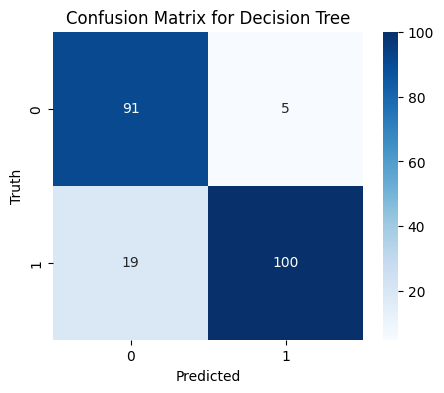

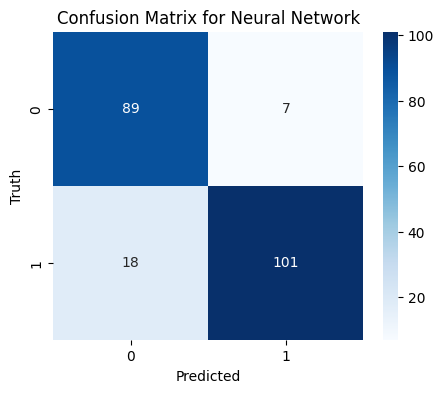

In [141]:
for key in results:
    # Predict the values from the validation dataset
    Y_pred = results[key].best_estimator_.predict(testing_inputs)

    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred)

    # Create the confusion matrix
    cm = confusion_matrix(testing_classes, Y_pred)

    plt.figure(figsize=(5, 4))
    sb.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.title('Confusion Matrix for ' + key)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')